# Term Subscription Predictions and Customer Analysis
### Gridsearch, PCA, and Modeling Notebook
##### Brittany Allen, February 2019

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#importing the usual suspects (packages/libraies)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
#scikit-learn libraries/packages

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
#classification packages

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation
from keras import regularizers
from keras.callbacks import EarlyStopping
#neural net libraries/packages

import random
#so I can set a random seed y'all

import warnings
warnings.simplefilter(action='ignore')
#preventing those ugly pink warnings from printing out

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#displayng my plots inline and changing the inline backeng default figure format so it's cleaner

Using TensorFlow backend.


In [2]:
random.seed(42)

#setting a global random seed for some element of reproducibility on my KNN and Neural Net models

In [3]:
bmd_df = pd.read_csv('./bank.csv')

#reading in my DataFrame and assigning it the variable 'bmd_df' – which stands for bank marketing DataFrame

In [4]:
bmd_df = bmd_df.drop(columns='duration')

#dropping this feature as it is known to highly influence the target

In [5]:
bmd_df.head()

#displaying the first five rows of my DataFrame

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,-1,0,unknown,yes


In [6]:
bmd_df.shape

#checking out the shape of my DataFrame

(11162, 16)

In [7]:
bmd_df.isnull().sum().sum()

#checking for nulls, there are none

0

In [8]:
bmd_df.deposit.value_counts(normalize=True)

#checking out the distribution of my target variable

no     0.52616
yes    0.47384
Name: deposit, dtype: float64

In [9]:
bmd_df['target'] = bmd_df.deposit.map(lambda x: 1 if x == 'yes' else 0)

#converting my target variable into '1s' and '0s' for my binary classification algorithms

In [10]:
b = [18, 35, 50, 72, 90, np.inf]
names = ['Millennials (18-34)', 
         'Gen X (35-49)',
         'Baby Boomers (50-71)',
         'Silent Gen (72-89)',
         'GI Gen (90+)']

bmd_df['age_group'] = pd.cut(x = bmd_df.age, bins = b, labels = names, right=False)

I engineered a new feature above, <b>age_group</b>, to bucket customers by their generational age groups as I think it will make data visualization and analysis easier and more meaningful.

In [11]:
bmd_df.head()

#displaying my head again to get a glimpse of the new feature I engineered

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit,target,age_group
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1,-1,0,unknown,yes,1,Baby Boomers (50-71)
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1,-1,0,unknown,yes,1,Baby Boomers (50-71)
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,-1,0,unknown,yes,1,Gen X (35-49)
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,1,-1,0,unknown,yes,1,Baby Boomers (50-71)
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,-1,0,unknown,yes,1,Baby Boomers (50-71)


# Feature Selection / Engineering / Transformation

In [12]:
bmd_df.columns

#getting a look at all of my columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous',
       'poutcome', 'deposit', 'target', 'age_group'],
      dtype='object')

In [13]:
to_poly = bmd_df.columns[bmd_df.dtypes != object]
to_poly = to_poly.drop(labels=['target', 'age_group'])

#creating a variable to house the features I'd like to create mass polynomial and interaction terms for

In [14]:
poly = PolynomialFeatures(include_bias=False)
X_poly = bmd_df[to_poly]

#instantiating the PolynomialFeatures pre-processor
#assigning a variable, X_poly, to house the DataFrame of features to be processed

In [15]:
X_poly = poly.fit_transform(X_poly)

#fitting and transforming my features

In [16]:
poly.get_feature_names(to_poly)

#displaying the feature names of my newly created polynomial and interaction terms

['age',
 'balance',
 'day',
 'campaign',
 'pdays',
 'previous',
 'age^2',
 'age balance',
 'age day',
 'age campaign',
 'age pdays',
 'age previous',
 'balance^2',
 'balance day',
 'balance campaign',
 'balance pdays',
 'balance previous',
 'day^2',
 'day campaign',
 'day pdays',
 'day previous',
 'campaign^2',
 'campaign pdays',
 'campaign previous',
 'pdays^2',
 'pdays previous',
 'previous^2']

In [17]:
bmd_df_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(to_poly))
bmd_df = bmd_df.join(bmd_df_poly[['age^2', 'age balance', 'age day', 'age campaign', 'age pdays', 'age previous',
                            'balance^2', 'balance day', 'balance campaign', 'balance pdays', 'balance previous',
                            'day^2', 'day campaign', 'day pdays', 'day previous', 'campaign^2', 'campaign pdays',
                            'campaign previous', 'pdays^2', 'pdays previous', 'previous^2']])
bmd_df.head()

#created a new DataFrame to house my new polynomial and interaction terms
#joined that new Dataframe with my existing one, bmd_df, and displayed the head to review the results

,age,job,marital,education,default,balance,housing,loan,contact,day,...,day^2,day campaign,day pdays,day previous,campaign^2,campaign pdays,campaign previous,pdays^2,pdays previous,previous^2
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,...,25.0,5.0,-5.0,0.0,1.0,-1.0,0.0,1.0,-0.0,0.0
1,56,admin.,married,secondary,no,45,no,no,unknown,5,...,25.0,5.0,-5.0,0.0,1.0,-1.0,0.0,1.0,-0.0,0.0
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,...,25.0,5.0,-5.0,0.0,1.0,-1.0,0.0,1.0,-0.0,0.0
3,55,services,married,secondary,no,2476,yes,no,unknown,5,...,25.0,5.0,-5.0,0.0,1.0,-1.0,0.0,1.0,-0.0,0.0
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,...,25.0,10.0,-5.0,0.0,4.0,-2.0,0.0,1.0,-0.0,0.0


In [18]:
to_dummy = (bmd_df.columns[bmd_df.dtypes != float]) & (bmd_df.columns[bmd_df.dtypes != int])
to_dummy = to_dummy.drop(labels='deposit')

#created a variable to house the categorical features I wanted to pre-process with one-hot encoding
#dropped my target variable

In [19]:
bmd_df = pd.get_dummies(bmd_df, columns=to_dummy, drop_first=True)
bmd_df.head()

#used Pandas' pd.get_dummies to transform my features into binary values and reassigned it back to my DataFrame

,age,balance,day,campaign,pdays,previous,deposit,target,age^2,age balance,...,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,age_group_Gen X (35-49),age_group_Baby Boomers (50-71),age_group_Silent Gen (72-89),age_group_GI Gen (90+)
0,59,2343,5,1,-1,0,yes,1,3481.0,138237.0,...,0,0,0,0,0,1,0,1,0,0
1,56,45,5,1,-1,0,yes,1,3136.0,2520.0,...,0,0,0,0,0,1,0,1,0,0
2,41,1270,5,1,-1,0,yes,1,1681.0,52070.0,...,0,0,0,0,0,1,1,0,0,0
3,55,2476,5,1,-1,0,yes,1,3025.0,136180.0,...,0,0,0,0,0,1,0,1,0,0
4,54,184,5,2,-1,0,yes,1,2916.0,9936.0,...,0,0,0,0,0,1,0,1,0,0


In [20]:
features = bmd_df.columns.drop(labels = ['deposit', 'target', 'age', 'balance', 
                                         'day', 'campaign','pdays', 'previous'])
features

#created a variable to house the features I planned to model with

Index(['age^2', 'age balance', 'age day', 'age campaign', 'age pdays',
       'age previous', 'balance^2', 'balance day', 'balance campaign',
       'balance pdays', 'balance previous', 'day^2', 'day campaign',
       'day pdays', 'day previous', 'campaign^2', 'campaign pdays',
       'campaign previous', 'pdays^2', 'pdays previous', 'previous^2',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes',
       'loan_yes', 'contact_telephone', 'contact_unknown', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown',
       'a

In [21]:
bmd_df.shape

#checking out the shape of my DataFrame now that new features have been added

(11162, 68)

In [22]:
X = bmd_df[features]
y = bmd_df.target

#creating my X and y variables

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=44, test_size=0.30)

#instantiating my train test split, passing the data to be split, setting a random state, and specifying my test size

In [24]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

#scaling my Xs

# CLASSIFICATION MODELING

### LOGISTIC REGRESSION MODELS

In [25]:
def run_the_lr_models(model):
    
    if model == 'lr_1':
        
        lr_1_params = {
            'penalty': ['l1'],
            'C': [1, 1.5, 2],
            'class_weight': [None, 'balanced'],
            'warm_start': [True, False],            
            'random_state': [42],
            'solver': ['liblinear']}
        
        M = GridSearchCV(LogisticRegression(),
                        lr_1_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'lr_2':
        
        lr_2_params = {
            'penalty': ['l2'],
            'C': [1, 1.5, 2],
            'class_weight': [None, 'balanced'],
            'warm_start': [True, False],            
            'random_state': [42],
            'solver': ['lbfgs', 'liblinear']}
        
        M = GridSearchCV(LogisticRegression(),
                        lr_2_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)

    else:
        print('There is an error.')
        
    M.fit(X_train, y_train)
     
    print(f'Train score = {M.score(X_train, y_train)}')
    print(f'Test score = {M.score(X_test, y_test)}')
    
    predictions = M.predict(X_test)
    print('--------')
    print(confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')

In [26]:
run_the_lr_models('lr_1')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   13.2s finished


Train score = 0.7152182260335338
Test score = 0.7100627052851598
--------
[[1436  302]
 [ 669  942]]
Best params = {'C': 1, 'class_weight': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'warm_start': True}


In [27]:
run_the_lr_models('lr_2')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s


Train score = 0.7156022014591066
Test score = 0.7121528814571514
--------
[[1439  299]
 [ 665  946]]
Best params = {'C': 1.5, 'class_weight': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'warm_start': True}


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   12.8s finished


#### Explaining the 3 cells above Logistic Regression

I defined a function to:

- GridSearch hyperparameters for two Logistic Regresssion Models
- Fit the models
- Print the train and test scores for the models
- Make predictions and print them in a confusion matrix
- Print out the best parameters

In the first cell following the function, I call `run_the_lr_models('lr_1')` which runs the first logistic regression model and in the next cell I call `run_the_lr_models('lr_2')` which runs the second model. The difference between the two models are the penalty. Some hyperparemeters only work with an L1 penalty while some only work with the L2 so I separated them based on that.

### DECISION TREE MODELS

In [28]:
def run_the_dt_models(model):
    
    if model == 'dt_1':
        
        dt_params = {
            'criterion': ['gini'],
            'max_depth': [4, 8, 12],
            'min_samples_split': [2, 3, 4],
            'max_features': [None, 'log2', 'auto', .50, .75, .99],
            'random_state': [42]}
        
        M = GridSearchCV(DecisionTreeClassifier(),
                        dt_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
   
    elif model == 'dt_2':
        
        dt_none_params = {
            'criterion': ['entropy'],
            'max_depth': [4, 8, 12],
            'min_samples_split': [4, 5, 6],
            'max_features': [None, 'log2', 'auto', .50, .75, .99],
            'random_state': [42]}
        
        M = GridSearchCV(DecisionTreeClassifier(),
                        dt_none_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)

    else:
        print('There is an error.')
        
    M.fit(X_train, y_train)
     
    print(f'Train score = {M.score(X_train, y_train)}')
    print(f'Test score = {M.score(X_test, y_test)}')
    
    predictions = M.predict(X_test)
    print('--------')
    print(confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')

In [29]:
run_the_dt_models('dt_1')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.9s


Train score = 0.734416997312172
Test score = 0.6861749776052553
--------
[[1445  293]
 [ 758  853]]
Best params = {'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'min_samples_split': 2, 'random_state': 42}


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   11.7s finished


In [30]:
run_the_dt_models('dt_2')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.4s


Train score = 0.7337770382695508
Test score = 0.6846819946252612
--------
[[1464  274]
 [ 782  829]]
Best params = {'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.99, 'min_samples_split': 5, 'random_state': 42}


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   14.2s finished


#### Explaining the 3 cells above for my Decision Tree models

I defined a function to:

- GridSearch hyperparameters for two Decision Tree Models
- Fit the models
- Print the train and test scores for the models
- Make predictions and print them in a confusion matrix
- Print out the best parameters

In the first cell following the function, I call `run_the_dt_models('dt_1')` which runs the first decision tree model and in the next cell I call `run_the_dt_models('dt_2')` which runs the second model. The difference between the two models are the criterion, I wanted one model that focused on gini and the other on entropy.

### RANDOM FOREST MODELS

In [32]:
def run_the_rf_models(model):
    
    if model == 'rf_1':
        
        rf_params = {
            'n_estimators': [15, 24, 30],
            'criterion': ['gini'],
            'max_depth': [5, 13, 21],
            'bootstrap': [True, False],
            'min_samples_split': [20, 25, 30],
            'max_features': [None, 'log2', 'auto', .50, .75, .99],
            'warm_start': [True, False],
            'random_state': [42]}
        
        M = GridSearchCV(RandomForestClassifier(),
                        rf_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'rf_2':
        
        rf_none_params = {
            'n_estimators': [25, 30, 35],
            'criterion': ['entropy'],
            'max_depth': [13, 21, 30],
            'bootstrap': [True, False],
            'min_samples_split': [25, 30, 35],
            'max_features': [None, 'log2', 'auto', .50, .75, .99],
            'warm_start': [True, False],
            'random_state': [42]}
        
        M = GridSearchCV(RandomForestClassifier(),
                        rf_none_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    else:
        print('There is an error.')
        
    M.fit(X_train, y_train)
     
    print(f'Train score = {M.score(X_train, y_train)}')
    print(f'Test score = {M.score(X_test, y_test)}')
    
    predictions = M.predict(X_test)
    print('--------')
    print(confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')

In [33]:
run_the_rf_models('rf_1')

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 28.3min finished


Train score = 0.8104441315755792
Test score = 0.7121528814571514
--------
[[1423  315]
 [ 649  962]]
Best params = {'bootstrap': True, 'criterion': 'gini', 'max_depth': 13, 'max_features': 0.5, 'min_samples_split': 25, 'n_estimators': 24, 'random_state': 42, 'warm_start': True}


In [34]:
run_the_rf_models('rf_2')

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 36.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 55.6min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 57.6min finished


Train score = 0.8764879047740944
Test score = 0.711257091669155
--------
[[1393  345]
 [ 622  989]]
Best params = {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 21, 'max_features': 'log2', 'min_samples_split': 30, 'n_estimators': 30, 'random_state': 42, 'warm_start': True}


#### Explaining the 3 cells above for my Random Forest models

I defined a function to:

- GridSearch hyperparameters for two Random Forest Models
- Fit the models
- Print the train and test scores for the models
- Make predictions and print them in a confusion matrix
- Print out the best parameters

In the first cell following the function, I call `run_the_rf_models('rf_1')` which runs the first random forest model and in the next cell I call `run_the_rf_models('rf_2')` which runs the second model. The difference between the two models are the criterion, I wanted one model that focused on gini and the other on entropy.

### KNN MODELS

In [35]:
def run_the_knn_models(model):
    
    if model == 'knn_1':
        
        knn_1_params = {
            'n_neighbors': [5, 50, 100],
            'weights': ['uniform'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [20, 30, 40]}
        
        M = GridSearchCV(KNeighborsClassifier(),
                        knn_1_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)

    elif model == 'knn_2':
        
        knn_1_params = {
            'n_neighbors': [5, 50, 100],
            'weights': ['distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [20, 30, 40]}
        
        M = GridSearchCV(KNeighborsClassifier(),
                        knn_1_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    else:
        print('There is an error.')
        
    M.fit(X_train, y_train)
     
    print(f'Train score = {M.score(X_train, y_train)}')
    print(f'Test score = {M.score(X_test, y_test)}')
    
    predictions = M.predict(X_test)
    print('--------')
    print(confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')

In [36]:
run_the_knn_models('knn_1')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 10.9min finished


Train score = 0.7159861768846794
Test score = 0.7064795461331741
--------
[[1501  237]
 [ 746  865]]
Best params = {'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 50, 'weights': 'uniform'}


In [37]:
run_the_knn_models('knn_2')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 10.4min finished


Train score = 1.0
Test score = 0.7049865631531801
--------
[[1475  263]
 [ 725  886]]
Best params = {'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 50, 'weights': 'distance'}


#### Explaining the 3 cells above for my KNN models

I defined a function to:

- GridSearch hyperparameters for two KNN Models
- Fit the models
- Print the train and test scores for the models
- Make predictions and print them in a confusion matrix
- Print out the best parameters

In the first cell following the function, I call `run_the_knn_models('knn_1')` which runs the first KNN model and in the next cell I call `run_the_knn_models('knn_2')` which runs the second model. The difference between the two models are the weights, I wanted one model that focused on uniform and the other on distance.

# NEURAL NETS

In [38]:
X_train.shape[1]

#checking out the shape of my X_train so I can know how many inputs are needed for my neural net below

60

### Sequential NN 1

In [39]:
seq1 = Sequential()
#instantiating my model

seq1.add(Dense(60, activation = 'relu', input_dim = 60))
seq1.add(Dropout(0.5))
seq1.add(Dense(48, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
seq1.add(Dropout(0.6))
seq1.add(Dense(3, activation = 'relu'))
seq1.add(Dense(1, activation = 'sigmoid'))
#neural net layers (input, hidden, and output)

seq1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#compiling the layers

e1 = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 2)
#early stopping

seq1_loss = seq1.fit(X_train, y_train, validation_data = (X_test, y_test), 
                     epochs = 1000, batch_size = 4000, verbose = 0, callbacks = [e1])
#fitting the model

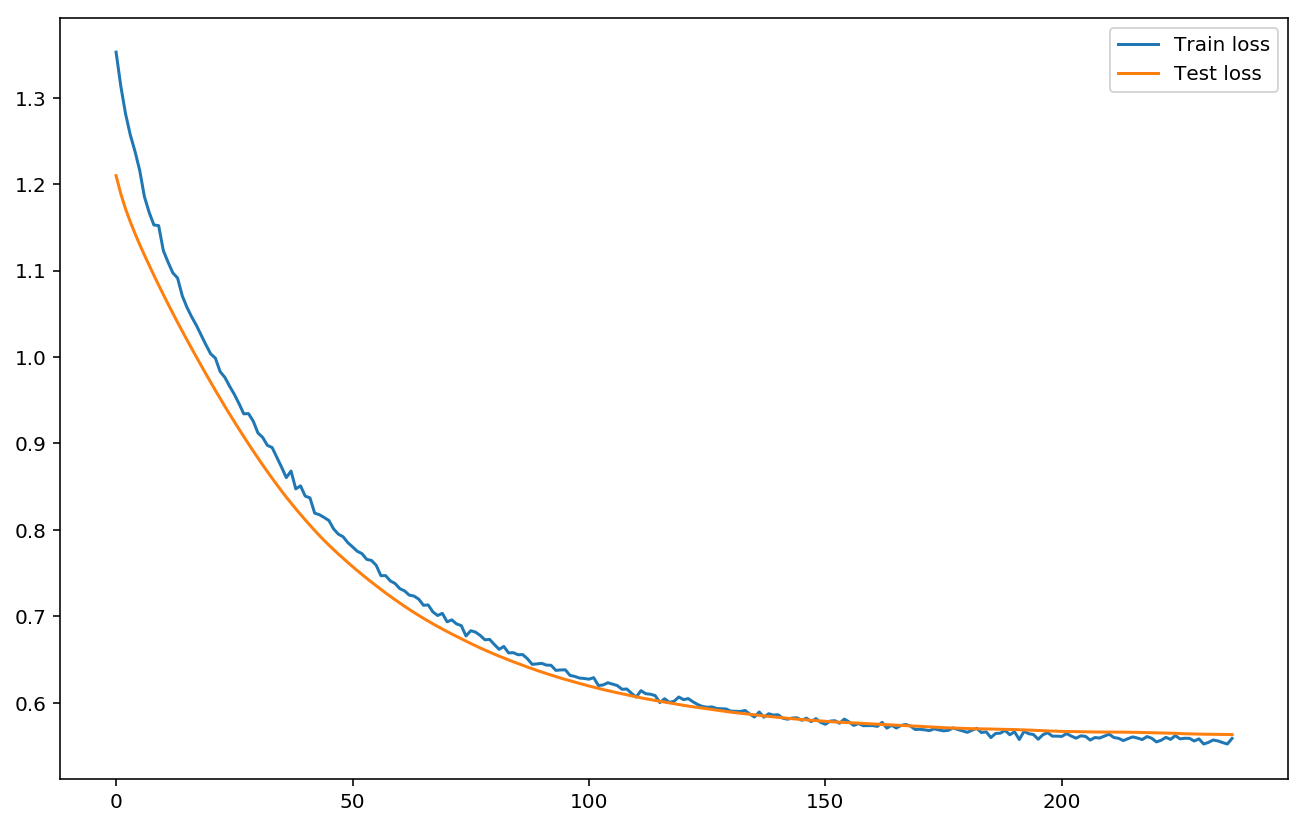

In [40]:
plt.figure(figsize = (11, 7))
plt.plot(seq1_loss.history['loss'], label = 'Train loss')
plt.plot(seq1_loss.history['val_loss'], label = 'Test loss')
plt.legend()
plt.show();

#plotting my train and test loss against each other

In [41]:
train_score_seq1 = seq1.evaluate(X_train, y_train, verbose = 0)
train_labels_seq1 = seq1.metrics_names

print(f'{train_labels_seq1[0]}: {train_score_seq1[0]}')
print(f'{train_labels_seq1[1]}: {train_score_seq1[1]}')

#printing out my train loss and accuracy score

loss: 0.5358024044278243
acc: 0.7488800716830417


In [42]:
test_score_seq1 = seq1.evaluate(X_test, y_test, verbose = 0)
test_labels_seq1 = seq1.metrics_names

print(f'{test_labels_seq1[0]}: {test_score_seq1[0]}')
print(f'{test_labels_seq1[1]}: {test_score_seq1[1]}')

#printing out my test loss and accuracy score

loss: 0.5631605843246144
acc: 0.7232009556158937


### Sequential NN 2

In [43]:
seq2 = Sequential()
#instantiating my model

seq2.add(Dense(60, activation = 'relu', input_dim = 60))
seq2.add(Dropout(0.5))
seq2.add(Dense(48, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
seq2.add(Dropout(0.6))
seq2.add(Dense(12, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
seq2.add(Dropout(0.5))
seq2.add(Dense(3, activation = 'relu'))
seq2.add(Dense(1, activation = 'sigmoid'))
#neural net layers (input, hidden, and output)

seq2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#compiling the layers

e2 = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 1)
#early stopping

seq2_loss = seq2.fit(X_train, y_train, validation_data = (X_test, y_test), 
                     epochs = 1000, batch_size = 4000, verbose = 0, callbacks = [e2])
#fitting the model

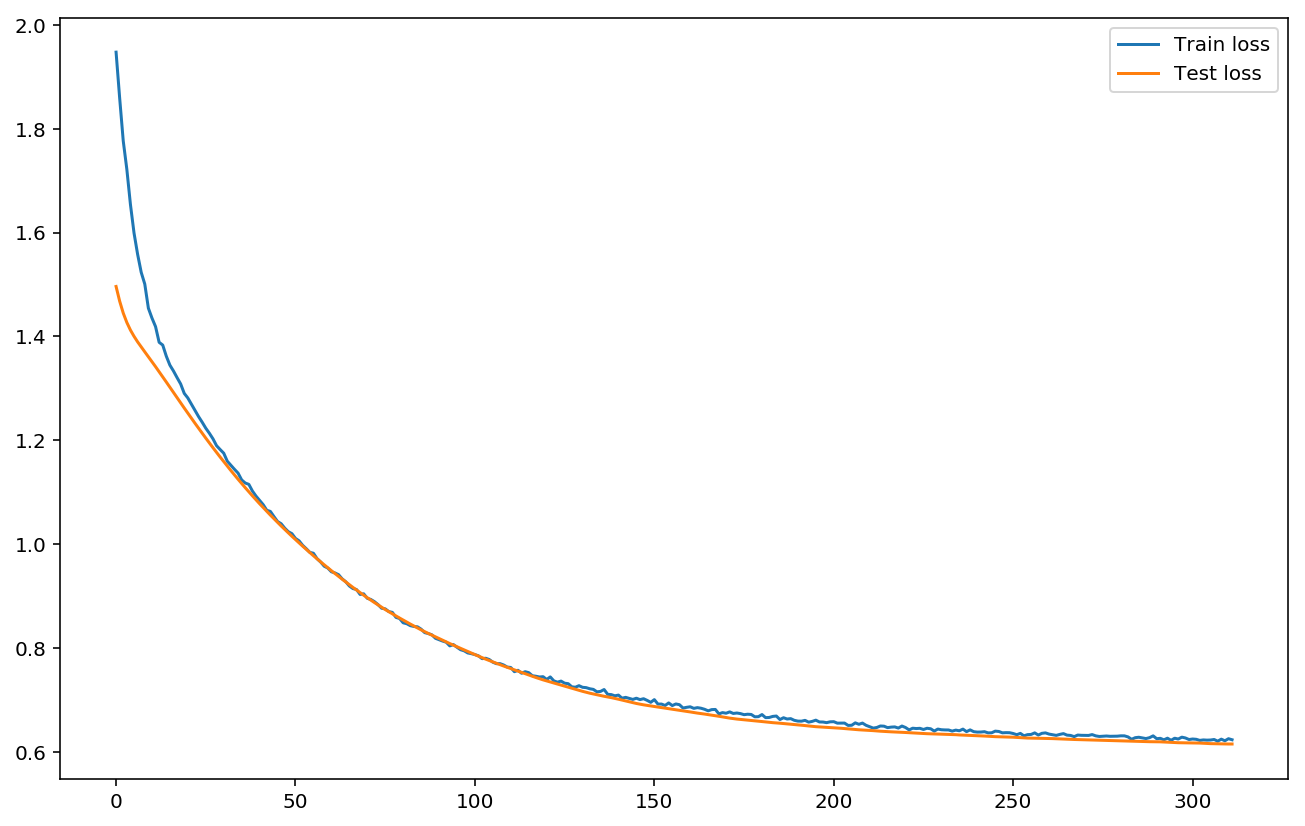

In [44]:
plt.figure(figsize = (11, 7))
plt.plot(seq2_loss.history['loss'], label = 'Train loss')
plt.plot(seq2_loss.history['val_loss'], label = 'Test loss')
plt.legend()
plt.show();

#plotting my train and test loss against each other

In [45]:
train_score_seq2 = seq2.evaluate(X_train, y_train, verbose = 0)
train_labels_seq2 = seq2.metrics_names

print(f'{train_labels_seq2[0]}: {train_score_seq2[0]}')
print(f'{train_labels_seq2[1]}: {train_score_seq2[1]}')

#printing out my train loss and accuracy score

loss: 0.6064596287224336
acc: 0.7282733905106367


In [46]:
test_score_seq2 = seq2.evaluate(X_test, y_test, verbose = 0)
test_labels_seq2 = seq2.metrics_names

print(f'{test_labels_seq2[0]}: {test_score_seq2[0]}')
print(f'{test_labels_seq2[1]}: {test_score_seq2[1]}')

#printing out my test loss and accuracy score

loss: 0.6152381151425158
acc: 0.7187220066581138
